In [121]:
import sent2vec
cleaned_expression_data = [line.strip().split("\t") for line in open("../gold_standard_sentences/clean_with_negative_otherexpr.csv")]
cleaned_kinaseact_data = [line.strip().split("\t") for line in open("../gold_standard_sentences/clean_with_negative_kinaseact.csv")]
cleaned_expression_data = [[row[0], int(row[1]), row[2]] for row in cleaned_expression_data]
cleaned_kinaseact_data = [[row[0], int(row[1]), row[2]] for row in cleaned_kinaseact_data]
bio_sent_vec_model_location = "../biosentvec/model.bin"

In [122]:
model_path = bio_sent_vec_model_location
biosentvec_model = sent2vec.Sent2vecModel()
try:
    biosentvec_model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


In [123]:
corpus_expr = biosentvec_model.embed_sentences([row[0] for row in cleaned_expression_data])
corpus_kinaseact = biosentvec_model.embed_sentences([row[0] for row in cleaned_kinaseact_data])

In [124]:
import umap

umap_reducer = umap.UMAP(metric='cosine')
corpus_expr_2d = umap_reducer.fit_transform(corpus_expr)
corpus_kinaseact_2d = umap_reducer.fit_transform(corpus_kinaseact)

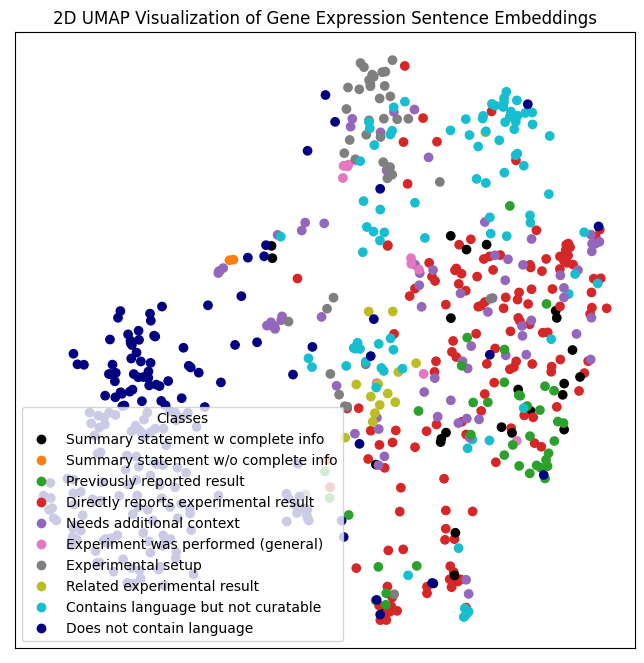

In [125]:
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

colors = ListedColormap(['black','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan', 'navy'])
values = [int(row[1]) for row in cleaned_expression_data]
classes = ['Summary statement w complete info', 'Summary statement w/o complete info', 'Previously reported result', 'Directly reports experimental result', 'Needs additional context', 'Experiment was performed (general)', 'Experimental setup', 'Related experimental result', 'Contains language but not curatable', 'Does not contain language']
fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(x=list(corpus_expr_2d[:,0]), y=list(corpus_expr_2d[:,1]), c=values, cmap=colors)
plt.xticks([])
plt.yticks([])
plt.title("2D UMAP Visualization of Gene Expression Sentence Embeddings")
legend = ax.legend(handles=scatter.legend_elements()[0], loc="lower left", title="Classes", labels=classes)

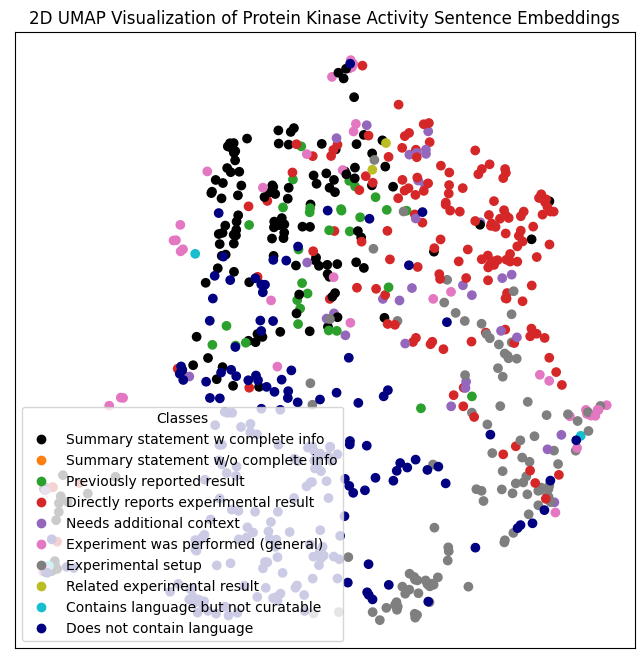

In [126]:
values = [int(row[1]) for row in cleaned_kinaseact_data]
fig, ax = plt.subplots(figsize=(8, 8))
plt.xticks([])
plt.yticks([])
plt.title("2D UMAP Visualization of Protein Kinase Activity Sentence Embeddings")
ax.scatter(x=list(corpus_kinaseact_2d[:,0]), y=list(corpus_kinaseact_2d[:,1]), c=values, cmap=colors)
legend = ax.legend(handles=scatter.legend_elements()[0], loc="lower left", title="Classes", labels=classes)

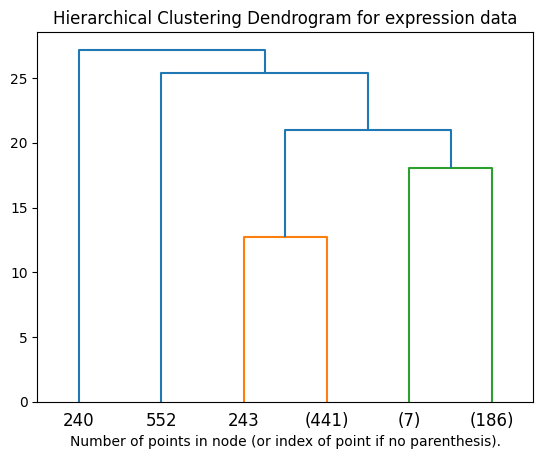

In [127]:
from sentence_classification.clustering import plot_dendrogram
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering

X_expr = corpus_expr

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0.2, n_clusters=None)

model_expr = model.fit(X_expr)
plt.title("Hierarchical Clustering Dendrogram for expression data")
# plot the top three levels of the dendrogram
plot_dendrogram(model_expr, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

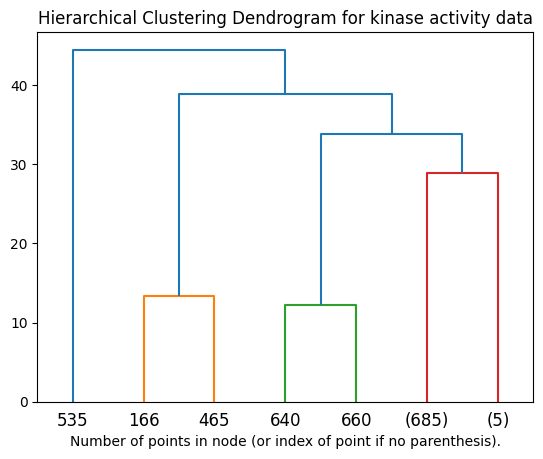

In [128]:
X_kinaseact = corpus_kinaseact

model_kinaseact = model.fit(X_kinaseact)
plt.title("Hierarchical Clustering Dendrogram for kinase activity data")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# classifiers

In [129]:
from random import shuffle
from sklearn.neural_network import MLPClassifier
import math

converted_corpus_expr = corpus_expr
converted_corpus_kinaseact = corpus_kinaseact
indices_expr = [i for i in range(len(corpus_expr))]
shuffle(indices_expr)
training_size_expr = math.ceil(len(corpus_expr) * 0.8)
training_indices_expr = indices_expr[0:training_size_expr]
test_indices_expr = indices_expr[training_size_expr:]
training_set_data_expr = [converted_corpus_expr[index] for index in training_indices_expr]
test_set_classes_expr = [cleaned_expression_data[index][1] for index in test_indices_expr]
indices_kinaseact = [i for i in range(len(corpus_kinaseact))]
shuffle(indices_kinaseact)
training_size_kinaseact = math.ceil(len(corpus_kinaseact) * 0.8)
training_indices_kinaseact = indices_kinaseact[0:training_size_kinaseact]
test_indices_kinaseact = indices_kinaseact[training_size_kinaseact:]
training_set_data_kinaseact = [converted_corpus_kinaseact[index] for index in training_indices_kinaseact]
test_set_classes_kinaseact = [cleaned_kinaseact_data[index][1] for index in test_indices_kinaseact]
base_clf = MLPClassifier(hidden_layer_sizes=(100, 100))

# prediction
## multiclass

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
training_set_classes_expr = [cleaned_expression_data[index][1] for index in training_indices_expr]
test_set_data_expr = [converted_corpus_expr[index] for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)
test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

In [131]:
training_set_classes_kinaseact = [cleaned_kinaseact_data[index][1] for index in training_indices_kinaseact]
test_set_data_kinaseact = [converted_corpus_kinaseact[index] for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)
test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.72222222 0.33333333 0.67741935 0.33333333 0.83333333 0.82352941
 0.925     ]
recall: [0.86666667 0.14285714 0.77777778 0.22222222 0.83333333 0.82352941
 0.86046512]
fscore: [0.78787879 0.2        0.72413793 0.26666667 0.83333333 0.82352941
 0.89156627]
support: [30  7 27  9  6 17 43]


## binary
### 1. Classifier that extracts sentences that contain all the information necessary to make an annotation.

In [132]:
import joblib
training_set_classes_expr = [1 if cleaned_expression_data[index][1] in [0, 3] else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][1] in [0, 3] else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)
joblib.dump(clf, '../classifiers/all_info_expression.joblib')

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.94444444 0.67567568]
recall: [0.87628866 0.83333333]
fscore: [0.90909091 0.74626866]
support: [97 30]


In [133]:
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr, average='weighted')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.8809557589085149
recall: 0.8661417322834646
fscore: 0.870628959711108
support: None


In [134]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] in [0, 3] and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] in [0, 3] and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)
joblib.dump(clf, '../classifiers/all_info_kinase.joblib')
test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.88461538 0.72131148]
recall: [0.80232558 0.83018868]
fscore: [0.84146341 0.77192982]
support: [86 53]


In [135]:
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.8223484264290963
recall: 0.8129496402877698
fscore: 0.8149506069085681
support: None


### 2. Classifier that extracts sentences that contain curatable information

In [136]:
training_set_classes_expr = [1 if cleaned_expression_data[index][1] in [0, 1, 3, 4] else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][1] in [0, 1, 3, 4] else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)
joblib.dump(clf, '../classifiers/curatable_expression.joblib')

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.96153846 0.7755102 ]
recall: [0.87209302 0.92682927]
fscore: [0.91463415 0.84444444]
support: [86 41]


In [137]:
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


precision: 0.9014820949579105
recall: 0.889763779527559
fscore: 0.8919744787999062
support: None


In [138]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] in [0, 1, 3, 4] and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] in [0, 1, 3, 4] and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)
joblib.dump(clf, '../classifiers/curatable_kinase.joblib')

test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.90666667 0.796875  ]
recall: [0.83950617 0.87931034]
fscore: [0.87179487 0.83606557]
support: [81 58]


In [139]:
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.8608543165467626
recall: 0.8561151079136691
fscore: 0.8568862438422528
support: None


### 3. Classifier that extracts sentences that contain language

In [140]:
training_set_classes_expr = [1 if cleaned_expression_data[index][1] < 9 else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][1] < 9 else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)
joblib.dump(clf, '../classifiers/language_expression.joblib')

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.95454545 0.97590361]
recall: [0.95454545 0.97590361]
fscore: [0.95454545 0.97590361]
support: [44 83]


In [141]:
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.968503937007874
recall: 0.968503937007874
fscore: 0.968503937007874
support: None


In [142]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] < 9 and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] < 9 and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)
joblib.dump(clf, '../classifiers/language_kinase.joblib')

test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.93846154 0.81081081]
recall: [0.81333333 0.9375    ]
fscore: [0.87142857 0.86956522]
support: [75 64]


In [143]:
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.8796871027086856
recall: 0.8705035971223022
fscore: 0.8705706242459448
support: None


# Feature analysis for positive sentences

## expression

(0.0, 210.0)

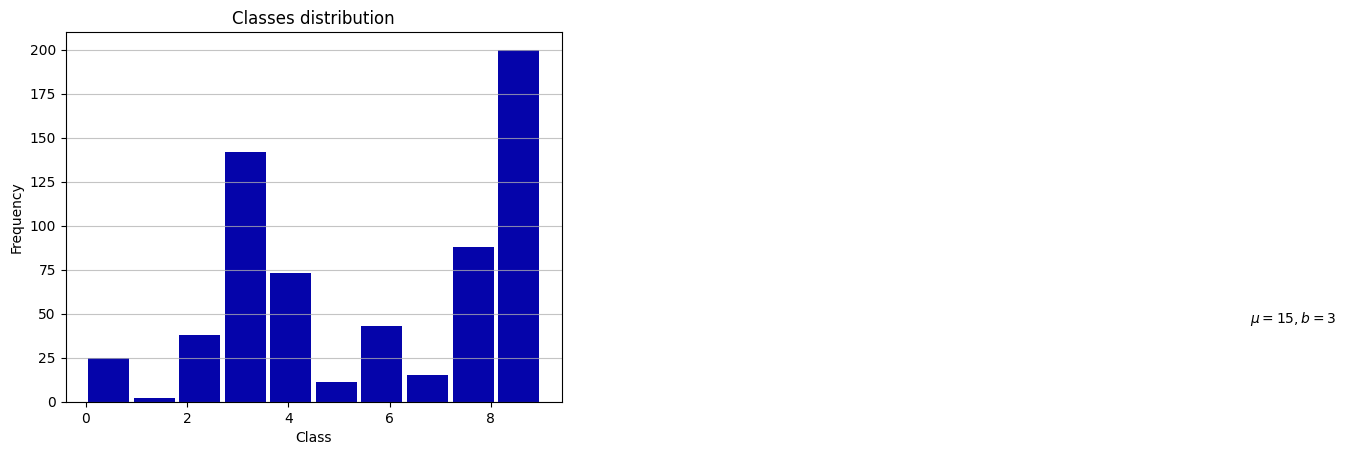

In [144]:
import matplotlib.pyplot as plt
import numpy as np

n, bins, patches = plt.hist(x=[r[1] for r in cleaned_expression_data], bins=10, color='#0504aa',
                            alpha=1, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Classes distribution')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

# kinase act

(0.0, 210.0)

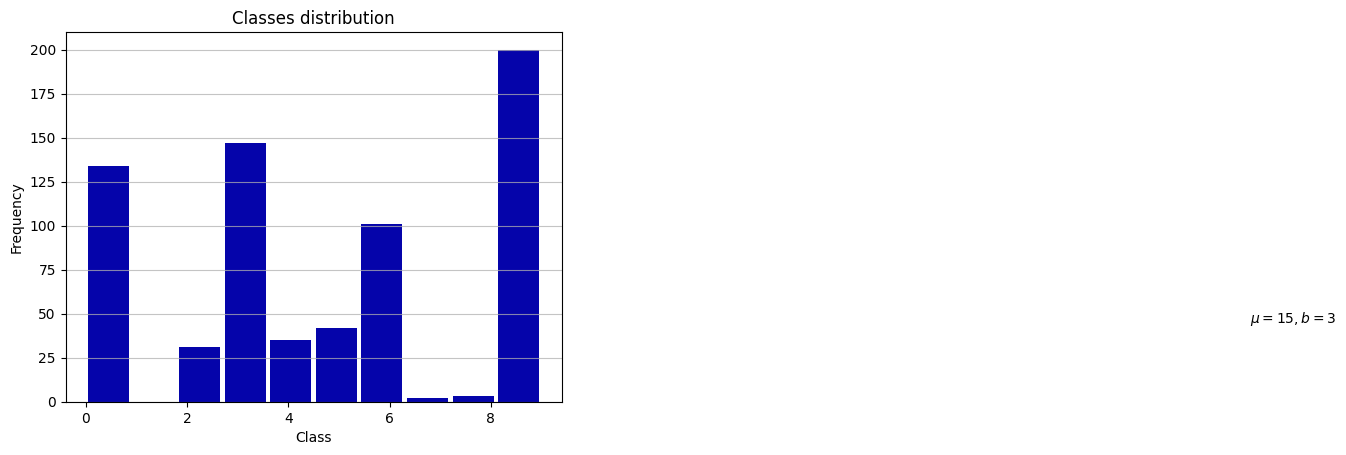

In [145]:
n, bins, patches = plt.hist(x=[r[1] for r in cleaned_kinaseact_data], bins=10, color='#0504aa',
                            alpha=1, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Classes distribution')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)